## Step 1 Load Data and Train-test Split

In [109]:
import numpy as np
from numpy import *
import random


def load_rating_data(file_path="../data/ml-latest-small/ratings.csv"):
    """
    load movie lens 100k ratings from original rating file.
    need to download and put rating data in /data folder first.
    Source: http://www.grouplens.org/
    """
    prefer = []
    for line in open(file_path, 'r'):  # 打开指定文件
        (userid, movieid, rating, ts) = line.split(',')  # 数据集中每行有4项
        if(userid=="userId"): continue
        uid = int(userid)
        mid = int(movieid)
        rat = float(rating)
        prefer.append([uid, mid, rat])
    data = array(prefer)
    return data

In [110]:
data=load_rating_data()
data

array([[1.00000e+00, 1.00000e+00, 4.00000e+00],
       [1.00000e+00, 3.00000e+00, 4.00000e+00],
       [1.00000e+00, 6.00000e+00, 4.00000e+00],
       ...,
       [6.10000e+02, 1.68250e+05, 5.00000e+00],
       [6.10000e+02, 1.68252e+05, 5.00000e+00],
       [6.10000e+02, 1.70875e+05, 3.00000e+00]])

In [111]:
new_data = data[data[:,1].argsort()]

In [112]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(new_data[:, 1])
a=le.transform(new_data[:, 1])
c=np.array(a).reshape(100836,1)

In [113]:
final_data = np.concatenate((new_data,c),axis=1)
final_data=final_data[:,[0,3,2]]

## Step2 Matrix Factorization (probabilistic-matrix-factorization)

In [167]:
import numpy as np

class PMF(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda1=0.1,_lambda2=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda1 = _lambda1  # L2 regularization,
        self._lambda2 = _lambda2  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)

        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors

        self.rmse_train = []
        self.rmse_test = []

    # ***Fit the model with train_tuple and evaluate RMSE on both train and test data.  ***********#
    # ***************** train_vec=TrainData, test_vec=TestData*************#
    
    def fit(self, train_vec, test_vec):
        # mean subtraction
        self.mean_inv = np.mean(train_vec[:, 2])  # rating mean

        pairs_train = train_vec.shape[0]  # the number of lines in traindata 
        pairs_test = test_vec.shape[0]  # the number of lines in testdata

        # 1-p-i, 2-m-c
        num_user = int(max(np.amax(train_vec[:, 0]), np.amax(test_vec[:, 0]))) + 1  # the total number of user
        num_item = int(max(np.amax(train_vec[:, 1]), np.amax(test_vec[:, 1]))) + 1  # the total number of movie
        print(num_item)

        incremental = False  
        if ((not incremental) or (self.w_Item is None)):
            # initialize
            self.epoch = 0
            self.w_Item = 0.1 * np.random.randn(num_item, self.num_feat)  # numpy.random.randn movie: M x D normal-distributed-matrix
            self.w_User = 0.1 * np.random.randn(num_user, self.num_feat)  # numpy.random.randn user: N x D normal-distributed-matrix

            self.w_Item_inc = np.zeros((num_item, self.num_feat))  # movie: M x D 0-matrix
            self.w_User_inc = np.zeros((num_user, self.num_feat))  # user: N x D 0-matrix

        while self.epoch < self.maxepoch:  # check the number of iterations
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  

            # Batch update
            for batch in range(self.num_batches):  
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  

                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Objective Function
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :],
                                              self.w_Item[batch_ItemID, :]),
                                  axis=1)  

                rawErr = pred_out - train_vec[shuffled_order[batch_idx], 2] + self.mean_inv

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda1 * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda2 * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Objective Function after
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(train_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(train_vec[:, 1], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - train_vec[:, 2] + self.mean_inv
                    obj = 0.5*np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda1 * np.linalg.norm(self.w_User) ** 2 + 0.5 * self._lambda2 * np.linalg.norm(self.w_Item) ** 2

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(test_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(test_vec[:, 1], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - test_vec[:, 2] + self.mean_inv
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_test))

                    # Print info
                    if batch == self.num_batches - 1:
                        print('Training RMSE: %f, Test RMSE %f' % (self.rmse_train[-1], self.rmse_test[-1]))

    def predict(self):
        return np.dot(self.w_Item, self.w_User) + self.mean_inv  

    # ****************Set parameters by providing a parameter dictionary.  ***********#
    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda1 = parameters.get("_lambda1", 0.1)
            self._lambda2 = parameters.get("_lambda2", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)

Run Example

610 9724 10
9724
Training RMSE: 0.737399, Test RMSE 1.039101
Training RMSE: 0.736145, Test RMSE 1.039001
Training RMSE: 0.734607, Test RMSE 1.038610
Training RMSE: 0.732120, Test RMSE 1.037399
Training RMSE: 0.727254, Test RMSE 1.033940
Training RMSE: 0.717163, Test RMSE 1.025236
Training RMSE: 0.699006, Test RMSE 1.008388
Training RMSE: 0.674517, Test RMSE 0.986100
Training RMSE: 0.648694, Test RMSE 0.964489
Training RMSE: 0.624617, Test RMSE 0.946530


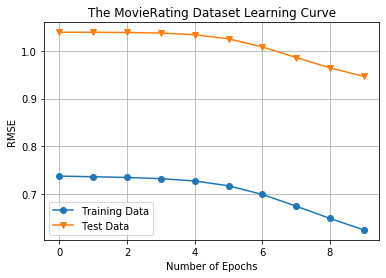

In [168]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

if __name__ == "__main__":
    #file_path = "data/ml-100k/ratings.csv"
    pmf = PMF()
    pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 10, "num_batches": 100,
                    "batch_size": 1000})
    print(len(np.unique(final_data[:, 0])), len(np.unique(final_data[:, 1])), pmf.num_feat)
    train, test = train_test_split(final_data)
    pmf.fit(train, test)

    # Check performance by plotting train and test errors
    plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
    plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
    plt.title('The MovieRating Dataset Learning Curve')
    plt.xlabel('Number of Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid()
    plt.show()


# pred_rating matrix

In [169]:
a=np.dot(pmf.w_User,pmf.w_Item.T) + pmf.mean_inv 
pred_matrix_final=a[:-1,]
np.shape(pred_matrix_final)

(610, 9724)

# Step 2.2 Parameter Tuning

In [170]:
num_feat_list=np.arange(10,30,10)
lambda1_list=np.array([0.01,0.1])
lambda2_list=np.array([0.01,0.1])

In [185]:
a=np.zeros((8,3))

In [191]:
a[0:4,0]=10
a[c(0,1,4,5),1]=0.01
a[,2]=0.1
a[4:,0]=20
a

SyntaxError: invalid syntax (<ipython-input-191-4835a8307e49>, line 3)

In [180]:
x,y,z=meshgrid(num_feat_list,lambda1_list,lambda2_list)

In [177]:
fig, axs = plt.subplots(2,8)

for i in num_feat_list:
    for j in lambda1_list:
        for z in lambda2_list:
            pmf.set_params({"num_feat": i, "epsilon": 1, "_lambda": j, "momentum": 0.8, "maxepoch": 10, "num_batches": 100,
                    "batch_size": 1000})
            print('num_latent =',i,'lambda for user =',j,'lambda for movie =',z)
            kf = KFold(n_splits=5)
            train_error=[]
            test_error=[]
            for train_index, test_index in kf.split(final_data):
                X_train, X_test = final_data[train_index], final_data[test_index]
                pmf.fit(X_train, X_test)
            train_error.append(pmf.rmse_train[-10:])
            test_error.append(pmf.rmse_test[-10:])
            RMSE_train=np.mean(train_error,axis=0)
            RMSE_test=np.mean(test_error,axis=0)
            print('For Training DataSet',RMSE_train)
            print('For Testing DataSet',RMSE_test)
            axs[i].plot()
plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
plt.title('The MovieRating Dataset Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()                

num_latent = 10 lambda for user = 0.01 lambda for movie = 0.01
9724
Training RMSE: 0.735262, Test RMSE 1.050196
Training RMSE: 0.734031, Test RMSE 1.050081
Training RMSE: 0.732353, Test RMSE 1.049989
Training RMSE: 0.729169, Test RMSE 1.049905
Training RMSE: 0.722163, Test RMSE 1.049747
Training RMSE: 0.707304, Test RMSE 1.049630
Training RMSE: 0.683121, Test RMSE 1.049644
Training RMSE: 0.655183, Test RMSE 1.049837
Training RMSE: 0.630495, Test RMSE 1.050077
Training RMSE: 0.609955, Test RMSE 1.050253
9724
Training RMSE: 0.735031, Test RMSE 1.054235
Training RMSE: 0.733862, Test RMSE 1.054254
Training RMSE: 0.732258, Test RMSE 1.054343
Training RMSE: 0.729076, Test RMSE 1.054580
Training RMSE: 0.721854, Test RMSE 1.055068
Training RMSE: 0.707303, Test RMSE 1.055924
Training RMSE: 0.686374, Test RMSE 1.057107
Training RMSE: 0.663237, Test RMSE 1.058382
Training RMSE: 0.640156, Test RMSE 1.059595
Training RMSE: 0.618926, Test RMSE 1.060720
9724
Training RMSE: 0.731858, Test RMSE 1.06903

KeyboardInterrupt: 

## Another Method

In [71]:
pred_matrix_final=a[:-1,np.unique(data[:, 1]).astype(int)]
pred_matrix_final

array([[3.43424716, 3.37180204, 3.3881135 , ..., 3.44704004, 3.53734453,
        3.46787001],
       [4.30212109, 3.76408681, 3.66534113, ..., 3.57861016, 3.49455719,
        3.53965215],
       [3.53063663, 3.57472247, 3.55362408, ..., 3.50121836, 3.48090632,
        3.50198032],
       ...,
       [3.62664609, 3.63409309, 3.65161604, ..., 3.41078218, 3.53346575,
        3.42999262],
       [3.61838983, 3.00923286, 2.90620857, ..., 3.62595927, 3.50642925,
        3.46644537],
       [3.45118029, 3.36972855, 3.44191247, ..., 3.4783898 , 3.49634485,
        3.50504771]])

In [72]:
np.shape(pred_matrix_final)

(610, 9724)

In [73]:
np.max(pred_matrix_final)

5.486883246437346

In [74]:
np.min(pred_matrix_final)

1.083585193767703

In [104]:
a=np.argsort(data[:,1])
data[:, 1][a]

array([1.00000e+00, 1.00000e+00, 1.00000e+00, ..., 1.93585e+05,
       1.93587e+05, 1.93609e+05])

In [132]:
new_data = data[data[:,1].argsort()]
len(np.unique(new_data[:,1]))

9724

In [157]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(new_data[:, 1])
le.classes_
a=le.transform(new_data[:, 1])
c=np.array(a).reshape(100836,1)
np.shape(c)


(100836, 1)

In [158]:
np.shape(new_data)

(100836, 3)

In [162]:
final_data = np.concatenate((new_data,c),axis=1)
final_data[30000]

array([ 275., 1333.,    4., 1021.])

In [164]:
ff=pd.DataFrame(final_data)

In [165]:
ff.columns = ['user','moive','rating',
                     'new_movie_id']

In [ ]:
ff1=array()